# (Traditional) Autoencoder

In [1]:
import torch  
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from typing import List

### Helper Class for logging trainings data

In [2]:
class TrainDataLogger():
    '''Helper class that stores informatoion during training'''
    def __init__(self) -> None:
        self.ls_losses:List[float] = []

        '''important for visualization'''
        self.ls_epochs:List[int]    = []
        self.ls_imgs:List[torch.Tensor]  = []
        self.ls_recimgs:List[torch.Tensor]  = [] 
        pass 

### Visualization

In [3]:
import matplotlib.pyplot as plt 

In [4]:
# plot loss per epoch
def plot_losses(losses) -> None:
    '''plots loss per epoch'''
    epochs = range(1, len(losses)+1)

    xticks = range(min(epochs), max(epochs)+1) # transforms into integer

    plt.plot(epochs, losses)
    plt.title('Loss per epoch'), plt.ylabel('Loss'),  plt.xlabel('Epoch')
    plt.xticks(xticks)
    plt.legend()
    plt.show()

    return

### Data

In [6]:
# DATA LOADER
transform = transforms.ToTensor()

data_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
data_test = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(data_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=True)

In [7]:
# DATA: look at pixels value range (important for activation function in decoder)
imgs, labels = next(iter(train_dataloader))

print( torch.min(imgs)  , torch.max(imgs) )

tensor(0.) tensor(1.)


### Class: Autoencoder (Fully Connected)

In [8]:
class Autoencoder_Linear(nn.Module):
    '''AE using fully connected layers'''
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 10),
        ) 
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        return

    def forward(self, x):
        return self.decoder(self.encoder(x))

### Train & Test functions

In [9]:
import math 

def train(epochs: int, model: nn.Module, dataloader: DataLoader, optimizer: optim.Optimizer, criterion) -> TrainDataLogger:
    n_batches = len(dataloader)
    train_data: TrainDataLogger = TrainDataLogger()
    
    model.train()
    for i_epoch in range(epochs):
        loss_epoch = 0
        for i_batch, (X,_) in enumerate(dataloader):

            # adjust shahpe of tensor, so that it fits into first layer
            X = X.reshape(-1, 28*28) 

            # pred (encode & decode)
            recon = model(X)

            # loss (how much difference between each pixel)
            loss = criterion(recon, X)
            if math.isnan(loss): 
                print(f'NAN @ epoch={i_epoch}, batch={i_batch}')
                return
            loss_epoch += loss

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # print
            if i_batch % 250 == 0:
                print(f'Epoch\t{i_epoch+1}/{epochs}\t\tBatch\t{i_batch}/{n_batches}\t({(100. * i_batch / n_batches):.1f}%)\t\tLoss\t{loss:.4f}')
        
        # Save training data per epoch
        train_data.ls_losses.append(loss_epoch / n_batches)
        train_data.ls_imgs.append(X)
        train_data.ls_recimgs.append(recon)
        train_data.ls_epochs.append(i_epoch)


    return train_data

In [10]:
def test(model:nn.Module, dataloader:DataLoader, criterion) -> float:
    model.eval()

    n_batches = len(dataloader)
    loss = 0

    with torch.no_grad():
        for _, (X,_) in enumerate(dataloader):
            X = X.reshape(-1,  28*28)

            # pred 
            recon = model(X)

            # loss
            loss += criterion(recon, X)

        loss = loss / n_batches

    return loss

### Training

In [11]:
model1 = Autoencoder_Linear()
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-5)

In [12]:
train_data:TrainDataLogger = train(
    epochs=3, 
    model=model1, 
    dataloader=train_dataloader, 
    optimizer=optimizer, 
    criterion=criterion
    )

Epoch	1/3		Batch	0/938	(0.0%)		Loss	0.2309
Epoch	1/3		Batch	250/938	(26.7%)		Loss	0.0602
Epoch	1/3		Batch	500/938	(53.3%)		Loss	0.0473
Epoch	1/3		Batch	750/938	(80.0%)		Loss	0.0474
Epoch	2/3		Batch	0/938	(0.0%)		Loss	0.0463
Epoch	2/3		Batch	250/938	(26.7%)		Loss	0.0410
Epoch	2/3		Batch	500/938	(53.3%)		Loss	0.0418
Epoch	2/3		Batch	750/938	(80.0%)		Loss	0.0384
Epoch	3/3		Batch	0/938	(0.0%)		Loss	0.0370
Epoch	3/3		Batch	250/938	(26.7%)		Loss	0.0365
Epoch	3/3		Batch	500/938	(53.3%)		Loss	0.0352
Epoch	3/3		Batch	750/938	(80.0%)		Loss	0.0343


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


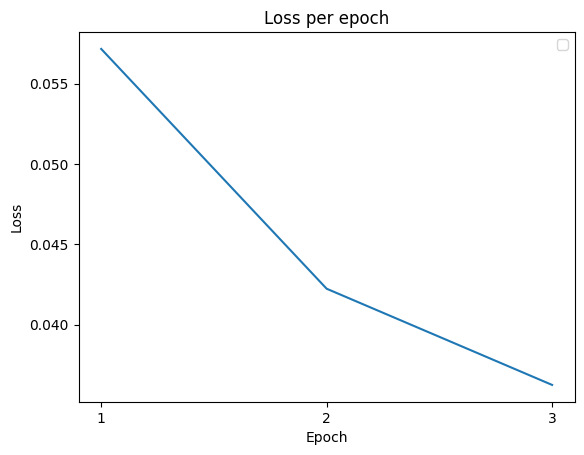

In [13]:
plot_losses(torch.Tensor(train_data.ls_losses))

In [14]:
test(model1, test_dataloader,  criterion).item()

0.03384784981608391

### Show generated images

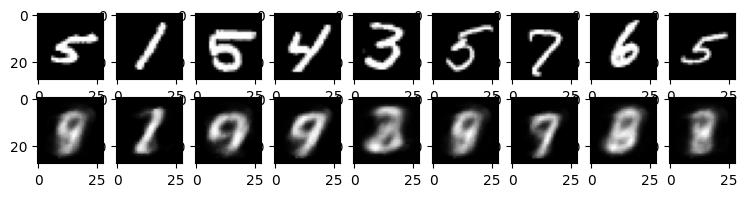

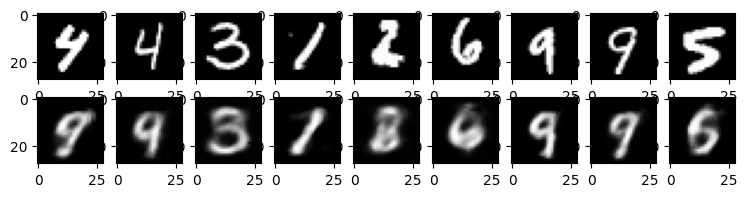

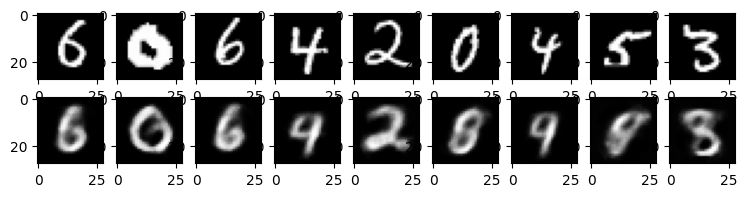

In [16]:
num_epochs = len(train_data.ls_epochs)

num_imgs_per_row = 9 
num_rows = 2


for i_epoch in range(0, num_epochs):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs    =  train_data.ls_imgs[i_epoch].detach().numpy()
    recimgs  = train_data.ls_recimgs[i_epoch].detach().numpy()

    for i, imgs_batch in enumerate(imgs):
        if i >= num_imgs_per_row : break

        plt.subplot(num_rows,num_imgs_per_row, i+1)
        imgs_batch = imgs_batch.reshape(-1, 28, 28)
        plt.imshow(imgs_batch[0])

    for i, imgs_batch in enumerate(recimgs):
        if i >= num_imgs_per_row : break

        plt.subplot(num_rows,num_imgs_per_row, i+1+num_imgs_per_row)
        imgs_batch = imgs_batch.reshape(-1, 28, 28)
        plt.imshow(imgs_batch[0])

plt.show()         